<a href="https://colab.research.google.com/github/dk-wei/dl-recomm-algo-implementation/blob/main/Wide_Deep_Cross_Networks_Keras%E5%AE%98%E6%96%B9%E4%BB%A3%E7%A0%81(%E5%BC%BA%E6%8E%A8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Structured data learning with Wide, Deep, and Cross networks

**Author:** [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)<br>
**Date created:** 2020/12/31<br>
**Last modified:** 2021/05/05<br>
**Description:** Using Wide & Deep and Deep & Cross networks for structured data classification.    
**Source:** https://keras.io/examples/structured_data/wide_deep_cross_networks/

## Introduction

This example demonstrates how to do structured data classification using the two modeling
techniques:

1. [Wide & Deep](https://ai.googleblog.com/2016/06/wide-deep-learning-better-together-with.html) models
2. [Deep & Cross](https://arxiv.org/abs/1708.05123) models

Note that this example should be run with TensorFlow 2.5 or higher.

## The dataset

This example uses the [Covertype](https://archive.ics.uci.edu/ml/datasets/covertype) dataset from the UCI
Machine Learning Repository. The task is to predict forest cover type from cartographic variables.
The dataset includes 506,011 instances with 12 input features: 10 numerical features and 2
categorical features. Each instance is categorized into 1 of 7 classes.

## Setup

In [3]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Prepare the data

First, let's load the dataset from the UCI Machine Learning Repository into a Pandas
DataFrame:

In [4]:
data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
)
raw_data = pd.read_csv(data_url, header=None)
print(f"Dataset shape: {raw_data.shape}")
raw_data.head()

Dataset shape: (581012, 55)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


The two categorical features in the dataset are binary-encoded.
We will convert this dataset representation to the typical representation, where each
categorical feature is represented as a single integer value.

In [5]:
soil_type_values = [f"soil_type_{idx+1}" for idx in range(40)]
wilderness_area_values = [f"area_type_{idx+1}" for idx in range(4)]

soil_type = raw_data.loc[:, 14:53].apply(
    lambda x: soil_type_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1
)
wilderness_area = raw_data.loc[:, 10:13].apply(
    lambda x: wilderness_area_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1
)

CSV_HEADER = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
    "Wilderness_Area",
    "Soil_Type",
    "Cover_Type",
]

data = pd.concat(
    [raw_data.loc[:, 0:9], wilderness_area, soil_type, raw_data.loc[:, 54]],
    axis=1,
    ignore_index=True,
)
data.columns = CSV_HEADER

# Convert the target label indices into a range from 0 to 6 (there are 7 labels in total).
data["Cover_Type"] = data["Cover_Type"] - 1

print(f"Dataset shape: {data.shape}")
data.head().T

Dataset shape: (581012, 13)


,0,1,2,3,4
Elevation,2596,2590,2804,2785,2595
Aspect,51,56,139,155,45
Slope,3,2,9,18,2
Horizontal_Distance_To_Hydrology,258,212,268,242,153
Vertical_Distance_To_Hydrology,0,-6,65,118,-1
Horizontal_Distance_To_Roadways,510,390,3180,3090,391
Hillshade_9am,221,220,234,238,220
Hillshade_Noon,232,235,238,238,234
Hillshade_3pm,148,151,135,122,150
Horizontal_Distance_To_Fire_Points,6279,6225,6121,6211,6172


The shape of the DataFrame shows there are 13 columns per sample
(12 for the features and 1 for the target label).

Let's split the data into training (85%) and test (15%) sets.

In [6]:
train_splits = []
test_splits = []

for _, group_data in data.groupby("Cover_Type"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.85
    train_splits.append(group_data[random_selection])
    test_splits.append(group_data[~random_selection])

train_data = pd.concat(train_splits).sample(frac=1).reset_index(drop=True)
test_data = pd.concat(test_splits).sample(frac=1).reset_index(drop=True)

print(f"Train split size: {len(train_data.index)}")
print(f"Test split size: {len(test_data.index)}")

Train split size: 494107
Test split size: 86905


Next, store the training and test data in separate CSV files.

In [7]:
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False)
test_data.to_csv(test_data_file, index=False)

## Define dataset metadata

Here, we define the metadata of the dataset that will be useful for reading and parsing
the data into input features, and encoding the input features with respect to their types.

In [8]:
TARGET_FEATURE_NAME = "Cover_Type"

TARGET_FEATURE_LABELS = ["0", "1", "2", "3", "4", "5", "6"]

NUMERIC_FEATURE_NAMES = [
    "Aspect",
    "Elevation",
    "Hillshade_3pm",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Horizontal_Distance_To_Fire_Points",
    "Horizontal_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Slope",
    "Vertical_Distance_To_Hydrology",
]

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "Soil_Type": list(data["Soil_Type"].unique()),
    "Wilderness_Area": list(data["Wilderness_Area"].unique()),
}

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]

NUM_CLASSES = len(TARGET_FEATURE_LABELS)

## Experiment setup

Next, let's define an input function that reads and parses the file, then converts features
and labels into a[`tf.data.Dataset`](https://www.tensorflow.org/guide/datasets)
for training or evaluation.

In [9]:
def get_dataset_from_csv(csv_file_path, batch_size, shuffle=False):

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=True,
        shuffle=shuffle,
    )
    return dataset.cache()


Here we configure the parameters and implement the procedure for running a training and
evaluation experiment given a model.

In [10]:
learning_rate = 0.001
dropout_rate = 0.1
batch_size = 265
num_epochs = 50

hidden_units = [32, 32]


def run_experiment(model):

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
        loss = keras.losses.SparseCategoricalCrossentropy(),
        metrics = [keras.metrics.SparseCategoricalAccuracy()],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)

    test_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

    _, accuracy = model.evaluate(test_dataset, verbose=0)

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")


## Define model inputs

Now, define the inputs for the models as a dictionary, where the key is the feature name,
and the value is a `keras.layers.Input` tensor with the corresponding feature shape
and data type.

- name
- shape
- type

In [11]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, 
                shape=(), 
                dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, 
                shape=(), 
                dtype=tf.string
            )
    return inputs

## Encode features

We create two representations of our input features: sparse and dense:
1. In the **sparse** representation, the categorical features are encoded with one-hot
encoding using the `CategoryEncoding` layer. This representation can be useful for the
model to *memorize* particular feature values to make certain predictions.
2. In the **dense** representation, the categorical features are encoded with
low-dimensional embeddings using the `Embedding` layer. This representation helps
the model to *generalize* well to unseen feature combinations.

In [12]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

def encode_inputs(inputs, use_embedding=False):
  """
  numerical feature直接concatenate
  categorical feature则是选择one-hot encoding或者是embedding
  然后把numerical和categorical feature的embedding给concat起来
  
  wide part的准备则较少，基本上没有cross-product
  """
    encoded_features = []
    for feature_name in inputs:

        # categorical feature， 要么one-hot encodng, 要么就embedding
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int" if use_embedding else "binary",
            )

            # create embedding for sparse categorical feature
            if use_embedding:
                # Convert the string input values into integer indices.
                encoded_feature = lookup(inputs[feature_name])
                embedding_dims = int(math.sqrt(len(vocabulary)))
                # Create an embedding layer with the specified dimensions.
                embedding = layers.Embedding(
                    input_dim=len(vocabulary), output_dim=embedding_dims
                )
                # Convert the index values to embedding representations.
                encoded_feature = embedding(encoded_feature)
            
            # 不embedding，就直接扔到one hot encoding, lookup table起一个one-hot encoding的作用
            else:
                # Convert the string input values into a one hot encoding.
                encoded_feature = lookup(tf.expand_dims(inputs[feature_name], -1))
        
        # numerical feature, 该什么样还是什么样，不动
        else:
            # Use the numerical features as-is.
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)

        encoded_features.append(encoded_feature)

    all_features = layers.concatenate(encoded_features)
    return all_features


### A glimpse of Encoding 

In [39]:
inputs = create_model_inputs()
features = encode_inputs(inputs)
deep = encode_inputs(inputs, use_embedding=True)

In [41]:
# for each inputs we have defined name, shape nd type
inputs

{'Aspect': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'Aspect')>,
 'Elevation': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'Elevation')>,
 'Hillshade_3pm': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'Hillshade_3pm')>,
 'Hillshade_9am': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'Hillshade_9am')>,
 'Hillshade_Noon': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'Hillshade_Noon')>,
 'Horizontal_Distance_To_Fire_Points': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'Horizontal_Distance_To_Fire_Points')>,
 'Horizontal_Distance_To_Hydrology': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'Horizontal_Distance_To_Hydrology')>,
 'Horizontal_Distance_To_Roadways': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'Horizontal_Distance_To_Roadways')>,
 'Slope': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'Slope')>,
 'Soil_Type': <KerasTensor: shape=(None,) dtype

In [64]:
vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY['Soil_Type']
use_embedding = False

lookup = StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int" if use_embedding else "binary",
            )

lookup(inputs['Soil_Type'])

<KerasTensor: shape=(None, 40) dtype=float32 (created by layer 'string_lookup_32')>

可以看出[`StringLookup`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/StringLookup)起到了one-hot encoding的作用

In [65]:
vocab = ["a", "b", "c", "d"]
data = tf.constant([["a", "c", "d", "d"], ["d", "z", "b", "z"]])
layer = StringLookup(vocabulary=vocab, output_mode='binary')
layer(data)

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[0., 1., 0., 1., 1.],
       [1., 0., 1., 0., 1.]], dtype=float32)>

## Experiment 1: a baseline model

In the first experiment, let's create a multi-layer feed-forward network,
where the categorical features are one-hot encoded.

就是numerical feature和categorical feature (one-hot encoding)一起往NN里面怼

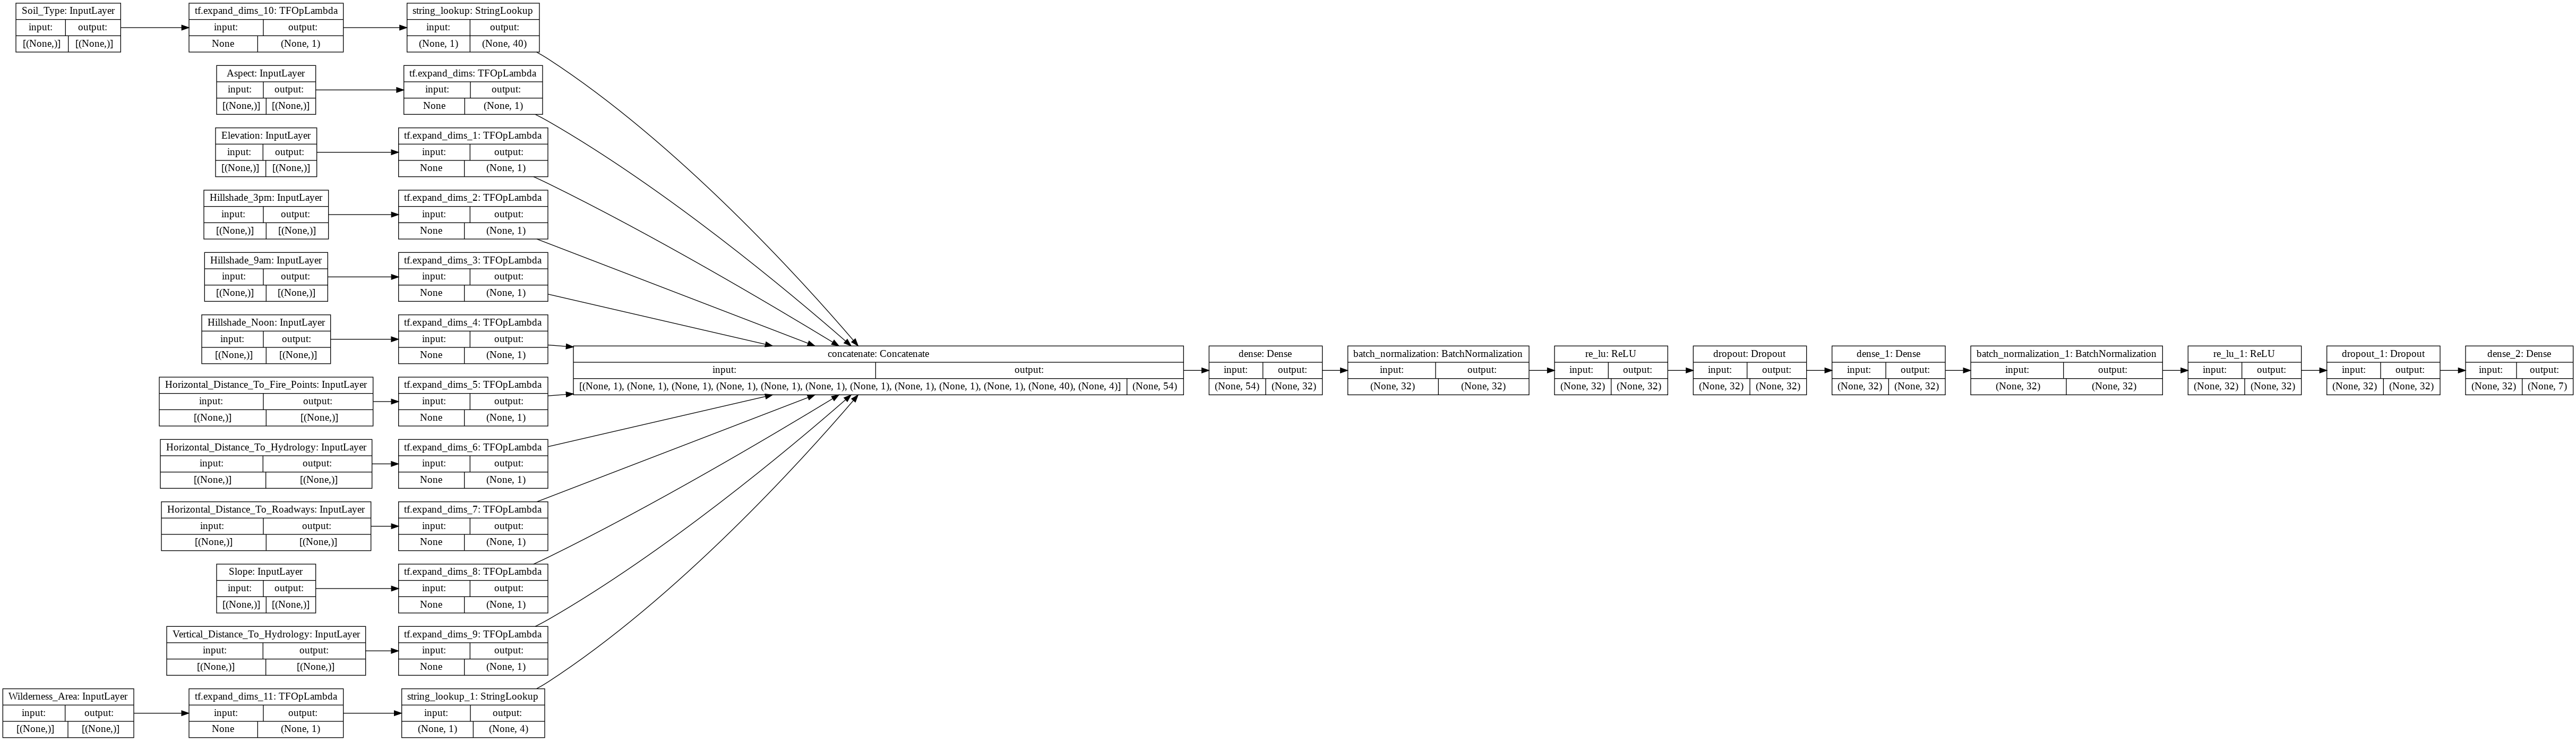

In [11]:
def create_baseline_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)

    for units in hidden_units:
        features = layers.Dense(units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.ReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

baseline_model = create_baseline_model()
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")

Let's run it:

In [12]:
run_experiment(baseline_model)

Start training the model...
Epoch 1/50
1865/1865 [==============================] - 21s 9ms/step - loss: 0.7763 - sparse_categorical_accuracy: 0.6803
Epoch 2/50
1865/1865 [==============================] - 11s 6ms/step - loss: 0.6645 - sparse_categorical_accuracy: 0.7126
Epoch 3/50
1865/1865 [==============================] - 11s 6ms/step - loss: 0.6394 - sparse_categorical_accuracy: 0.7245
Epoch 4/50
1865/1865 [==============================] - 11s 6ms/step - loss: 0.6209 - sparse_categorical_accuracy: 0.7335
Epoch 5/50
1865/1865 [==============================] - 11s 6ms/step - loss: 0.6096 - sparse_categorical_accuracy: 0.7390
Epoch 6/50
1865/1865 [==============================] - 11s 6ms/step - loss: 0.5994 - sparse_categorical_accuracy: 0.7432
Epoch 7/50
1865/1865 [==============================] - 11s 6ms/step - loss: 0.5904 - sparse_categorical_accuracy: 0.7468
Epoch 8/50
1865/1865 [==============================] - 11s 6ms/step - loss: 0.5845 - sparse_categorical_accuracy: 0.7

The baseline linear model achieves ~73% test accuracy.

## Experiment 2: Wide & Deep model

In the second experiment, we create a Wide & Deep model. The wide part of the model
a linear model, while the deep part of the model is a multi-layer feed-forward network.

Use the **sparse representation** of the input features in the **wide part** of the model and the
**dense representation** of the input features for the **deep part** of the model.

Note that every input features contributes to both parts of the model with different
representations.

**本例还是和原论文有所出入的，原论文wide只有`被推荐的app ☓ 用户下载的app`一组feature，其余continous和categorical (embedding)全部走的deep部分，而本示例代码中所有的feature (包括numerical feature) 都同时会进入wide和deep两个部分，只是wide部分采用的是non-embedding, 也就是one hot encoding，而deep部分则是use embedding，但是feature还是那些个feature。但是实际上，可以根据业务需求具体选择wide部分的feature**.

可以看到wide&deep的wide part其实有些被忽视了，cross-product的不够

![](https://pic3.zhimg.com/80/v2-65c4fdfefd2353d7ee3d1898365d353a_1440w.jpg)

![](https://pic3.zhimg.com/80/v2-454e014689c267d3093844af23d82f42_1440w.jpg)

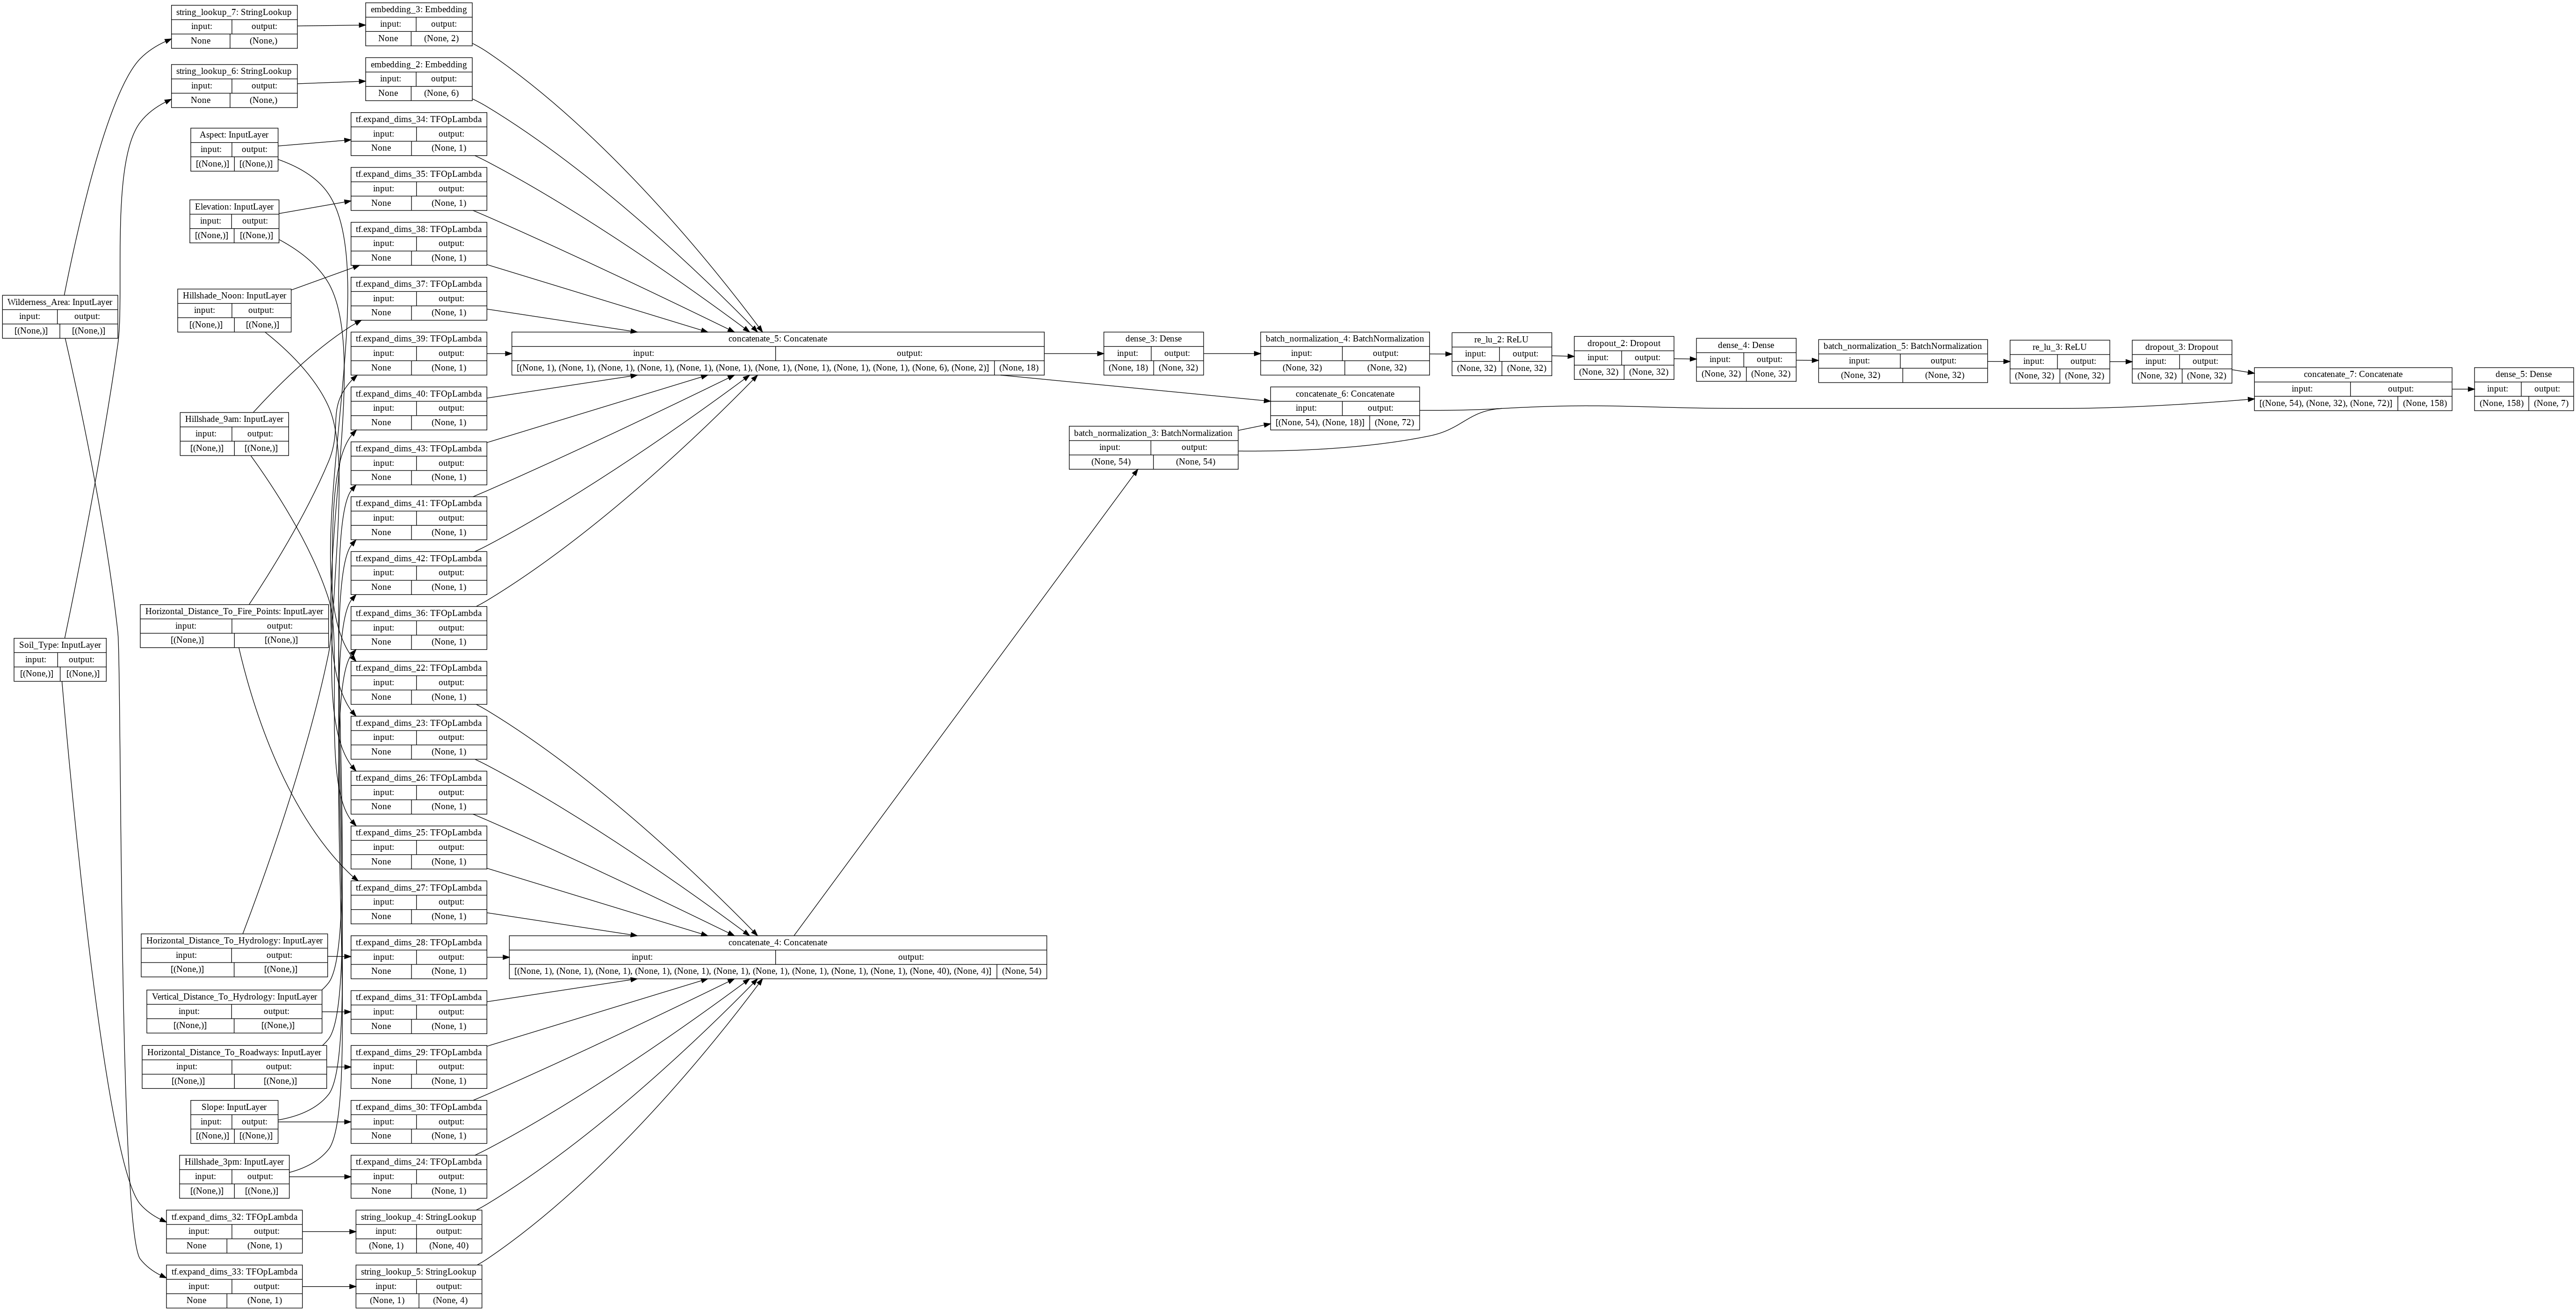

In [14]:
def create_wide_and_deep_model():

    inputs = create_model_inputs()
    wide = encode_inputs(inputs)
    wide = layers.BatchNormalization()(wide)

    # 叫是叫deep，其实已经是continous与catgorical的embedding一起concat了
    deep = encode_inputs(inputs, use_embedding=True)

    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([wide, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


wide_and_deep_model = create_wide_and_deep_model()
keras.utils.plot_model(wide_and_deep_model, show_shapes=True, rankdir="LR")

Let's run it:

In [14]:
run_experiment(wide_and_deep_model)

Start training the model...
Epoch 1/50
1865/1865 [==============================] - 23s 11ms/step - loss: 0.7121 - sparse_categorical_accuracy: 0.7014
Epoch 2/50
1865/1865 [==============================] - 15s 8ms/step - loss: 0.6050 - sparse_categorical_accuracy: 0.7376
Epoch 3/50
1865/1865 [==============================] - 15s 8ms/step - loss: 0.5869 - sparse_categorical_accuracy: 0.7449
Epoch 4/50
1865/1865 [==============================] - 14s 8ms/step - loss: 0.5735 - sparse_categorical_accuracy: 0.7501
Epoch 5/50
1865/1865 [==============================] - 14s 8ms/step - loss: 0.5647 - sparse_categorical_accuracy: 0.7550
Epoch 6/50
1865/1865 [==============================] - 14s 8ms/step - loss: 0.5570 - sparse_categorical_accuracy: 0.7579
Epoch 7/50
1865/1865 [==============================] - 14s 8ms/step - loss: 0.5512 - sparse_categorical_accuracy: 0.7613
Epoch 8/50
1865/1865 [==============================] - 14s 8ms/step - loss: 0.5462 - sparse_categorical_accuracy: 0.

The wide and deep model achieves ~80% test accuracy.

## Experiment 3: Deep & Cross model

In the third experiment, we create a Deep & Cross model. The deep part of this model
is the same as the deep part created in the previous experiment. The key idea of
the cross part is to apply explicit feature crossing in an efficient way,
where the degree of cross features grows with layer depth.

**相比于wide&deep，这个模型进行了大范围的cross-product**

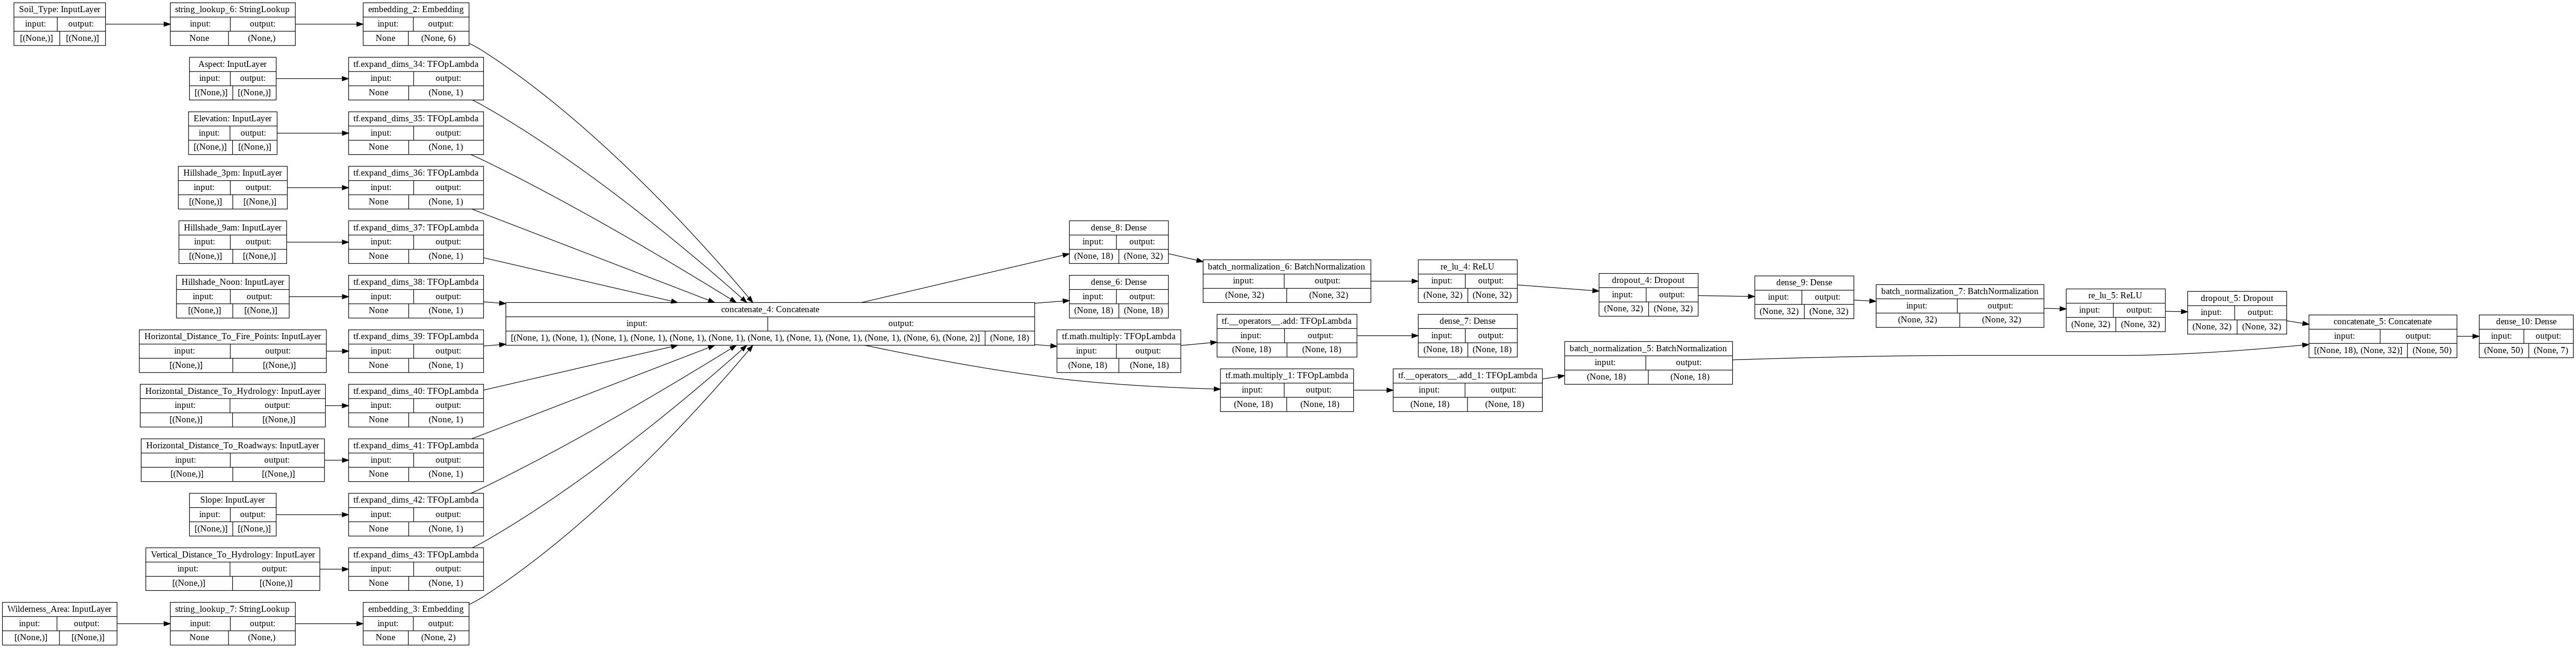

In [15]:

def create_deep_and_cross_model():

    inputs = create_model_inputs()
    x0 = encode_inputs(inputs, use_embedding=True)

    cross = x0
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)

    deep = x0
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([cross, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


deep_and_cross_model = create_deep_and_cross_model()
keras.utils.plot_model(deep_and_cross_model, show_shapes=True, rankdir="LR")

Let's run it:

In [16]:
run_experiment(deep_and_cross_model)

Start training the model...
Epoch 1/50
1865/1865 [==============================] - 22s 11ms/step - loss: 0.6850 - sparse_categorical_accuracy: 0.7154
Epoch 2/50
1865/1865 [==============================] - 14s 8ms/step - loss: 0.5921 - sparse_categorical_accuracy: 0.7438
Epoch 3/50
1865/1865 [==============================] - 14s 8ms/step - loss: 0.5692 - sparse_categorical_accuracy: 0.7528
Epoch 4/50
1865/1865 [==============================] - 14s 8ms/step - loss: 0.5578 - sparse_categorical_accuracy: 0.7575
Epoch 5/50
1865/1865 [==============================] - 14s 8ms/step - loss: 0.5502 - sparse_categorical_accuracy: 0.7613
Epoch 6/50
1865/1865 [==============================] - 14s 8ms/step - loss: 0.5436 - sparse_categorical_accuracy: 0.7642
Epoch 7/50
1865/1865 [==============================] - 14s 8ms/step - loss: 0.5397 - sparse_categorical_accuracy: 0.7656
Epoch 8/50
1865/1865 [==============================] - 14s 8ms/step - loss: 0.5354 - sparse_categorical_accuracy: 0.

The deep and cross model achieves ~81% test accuracy.

## Conclusion

You can use Keras Preprocessing Layers to easily handle categorical features
with different encoding mechanisms, including one-hot encoding and feature embedding.
In addition, different model architectures — like wide, deep, and cross networks
— have different advantages, with respect to different dataset properties.
You can explore using them independently or combining them to achieve the best result
for your dataset.